In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-dark-palette','dark_background'])
import warnings
warnings.filterwarnings(action = 'ignore')

In [22]:
data = pd.read_csv('Transformed_Housing_Data2.csv')
data.head()

,Sale_Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Condition_of_the_House_Excellent,Condition_of_the_House_Fair,Condition_of_the_House_Good,Condition_of_the_House_Okay,Ever_Renovated_Yes,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
0,221900.0,3,1.00,1180.0,5650.0,1.0,0,7,1180.0,0,63,47.5112,-122.257,1340.0,5650,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,2570.0,7242.0,2.0,0,7,2170.0,400,67,47.7210,-122.319,1690.0,7639,26,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
2,180000.0,2,1.00,770.0,10000.0,1.0,0,6,770.0,0,85,47.7379,-122.233,2720.0,8062,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960.0,5000.0,1.0,0,7,1050.0,910,53,47.5208,-122.393,1360.0,5000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,510000.0,3,2.00,1680.0,8080.0,1.0,0,8,1680.0,0,31,47.6168,-122.045,1800.0,7503,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


## Scaling the dataset

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = data['Sale_Price']
X = scaler.fit_transform(data.drop(columns = ['Sale_Price']))
X = pd.DataFrame(data = X, columns = data.drop(columns = ['Sale_Price']).columns)
X.head()

,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Condition_of_the_House_Excellent,Condition_of_the_House_Fair,Condition_of_the_House_Good,Condition_of_the_House_Okay,Ever_Renovated_Yes,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
0,-0.398724,-1.447526,-0.979905,-0.228291,-0.915389,-0.30579,-0.563993,-0.734722,-0.658697,0.544734,-0.352576,-0.306226,-0.943307,-0.260741,-0.167463,-0.292306,0.735132,-0.597003,-0.089574,-0.210155,-0.087181,-0.350481,-0.482158,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
1,-0.398724,0.175684,0.533718,-0.189858,0.936817,-0.30579,-0.563993,0.460990,0.245134,0.680915,1.161645,-0.746479,-0.432664,-0.187900,4.757239,-0.292306,0.735132,-0.597003,-0.089574,4.758385,-0.087181,-0.350481,2.074011,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
2,-1.474115,-1.447526,-1.426369,-0.123276,-0.915389,-0.30579,-1.468566,-1.229916,-0.658697,1.293731,1.283619,-0.135806,1.070082,-0.172409,-0.167463,-0.292306,0.735132,-0.597003,-0.089574,-0.210155,-0.087181,-0.350481,2.074011,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
3,0.676667,1.149611,-0.130534,-0.243983,-0.915389,-0.30579,-0.563993,-0.891735,1.397518,0.204281,-0.283288,-1.271941,-0.914127,-0.284546,-0.167463,3.421068,-1.360300,-0.597003,-0.089574,-0.210155,-0.087181,-0.350481,-0.482158,2.383223,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
4,-0.398724,-0.148958,-0.435436,-0.169628,-0.915389,-0.30579,0.340581,-0.130827,-0.658697,-0.544715,0.409587,1.199152,-0.272177,-0.192880,-0.167463,-0.292306,0.735132,-0.597003,-0.089574,-0.210155,-0.087181,-0.350481,-0.482158,-0.419600,2.087275,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158


## Train/Test set

In [0]:
X = data.drop(columns = ["Sale_Price"])
Y = data['Sale_Price']

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15126, 30), (6483, 30), (15126,), (6483,))

## Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
predictions = lr.predict(x_test)

In [28]:
lr.score(x_test, y_test)

0.846235554246878

# Forward selection

In [0]:
def adj_r2( m ,data_y, predictions):
  '''
  m : number of independent variables
  data_y : target variable
  predictions : prediction of the model to be evaluated

  Returns: Adjusted R2
  '''

  from sklearn.metrics import r2_score
  R = r2_score(data_y, predictions)
  n = len(data_y)
  adj_R = 1 - ((1-R)*(n-1))/(n-m-1)
  return adj_R

In [0]:
def return_r2(X, Y, model):
  '''
  X : independent variables
  Y : target variable
  model : predictive model

  Returns: Adjusted R2 corresponding to the model
  '''
  model.fit(X, Y)
  pred = model.predict(X)
  m = len(X.columns)
  r2 = adj_r2(m, Y, pred)
  return r2

In [0]:
def forward_selection(model, X, Y, max_features):
  '''
  X : independent variables
  Y : target variable
  model : predictive model
  max_features : selects best feature upto max_features value

  Returns: 
  Rmax : Adjusted R2 of the final model
  history : list of Rmax at every new independent variable added to the model
  x[f_col] : best features upto max_features
  '''
  
  f_col = []
  history = []
  
  for i in range(max_features):

    f_col.append('blank')
    tmp = f_col[:]
    Rmax = -1

    for var in X.columns:
      tmp[-1] = var
      r2 = return_r2( X[tmp] , Y, model)
      if r2 >= Rmax:
        Rmax = r2
        f_col[-1] = var
        elim = var
  
    print("Selected",f_col[-1],"with new r2 =",Rmax)
    history.append(Rmax)

  return Rmax, history, X[f_col]

In [32]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)

score, history, sel_data = forward_selection(lr, x_train, y_train, 5)

Selected Flat Area (in Sqft) with new r2 = 0.4825106645259518
Selected Latitude with new r2 = 0.6158682713046579
Selected Overall Grade with new r2 = 0.6693250844517911
Selected Age of House (in Years) with new r2 = 0.7101671809322652
Selected Zipcode_Group_Zipcode_Group_8 with new r2 = 0.7359659801896957


In [33]:
sel_data.columns

Index(['Flat Area (in Sqft)', 'Latitude', 'Overall Grade',
       'Age of House (in Years)', 'Zipcode_Group_Zipcode_Group_8'],
      dtype='object')

In [34]:
score

0.7359659801896957

# Backward Elimination

In [0]:
def adj_r2( m=0, data_y=0, predictions=0):
  '''
  m : number of independent variables
  data_y : target variable
  predictions : prediction of the model to be evaluated

  Returns: Adjusted R2
  '''

  from sklearn.metrics import r2_score
  R = r2_score(data_y, predictions)
  n = len(data_y)
  adj_R = 1 - ((1-R)*(n-1))/(n-m-1)
  return adj_R

In [0]:
def return_r2(X, Y, model):
  '''
  X : independent variables
  Y : target variable
  model : predictive model

  Returns: Adjusted R2 corresponding to the model
  '''
  model.fit(X, Y)
  pred = model.predict(X)
  m = len(X.columns)
  r2 = adj_r2(m, Y, pred)
  return r2

In [0]:
def backward_elimination( model, X, Y, min_features):
  '''
  X : independent variables
  Y : target variable
  model : predictive model
  min_features : eliminate worst features until only min_features are left

  Returns: 
  Rmax : Adjusted R2 of the final model
  history : list of Rmax at every new independent variable added to the model
  x[f_col] : best features upto max_features
  '''
  elim_data = X[:]
  r2_history = []
  base_r2 = return_r2(elim_data, Y, model)
  print("base_r2 is", base_r2)


  for i in range(X.shape[1] - min_features):
  
    difference = -100

    for var in elim_data.columns:
      tmp = elim_data.drop(columns = [var])
      r2 = return_r2(tmp, Y, model)

      if (r2 - base_r2) > difference:
        difference = r2 - base_r2
        eliminate = var
        new_r2 = r2
  
    elim_data.drop(columns = [eliminate], inplace = True)
    r2_history.append(new_r2)
    print(eliminate,"Eliminated : New adj_r2 = ",new_r2,)
    base_r2 = new_r2

  return base_r2, r2_history, elim_data

In [38]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)

score , history, survided_data = backward_elimination(lr, x_train, y_train, 1)

base_r2 is 0.8411713183817104
Area of the House from Basement (in Sqft) Eliminated : New adj_r2 =  0.8411797446658431
Condition_of_the_House_Okay Eliminated : New adj_r2 =  0.8411623663620638
No of Floors Eliminated : New adj_r2 =  0.8411171250786781
Lot Area after Renovation (in Sqft) Eliminated : New adj_r2 =  0.8410610037918913
No of Bedrooms Eliminated : New adj_r2 =  0.8409159992800566
Condition_of_the_House_Fair Eliminated : New adj_r2 =  0.8407704362899256
Condition_of_the_House_Good Eliminated : New adj_r2 =  0.8404605503169835
Years Since Renovation Eliminated : New adj_r2 =  0.8399491254999183
Ever_Renovated_Yes Eliminated : New adj_r2 =  0.839408914973874
No of Bathrooms Eliminated : New adj_r2 =  0.8384257980145962
Living Area after Renovation (in Sqft) Eliminated : New adj_r2 =  0.8371253089016231
Waterfront_View_Yes Eliminated : New adj_r2 =  0.8356698063157927
Zipcode_Group_Zipcode_Group_1 Eliminated : New adj_r2 =  0.8339600690154836
Lot Area (in Sqft) Eliminated : New 

In [39]:
history

[0.8411797446658431,
 0.8411623663620638,
 0.8411171250786781,
 0.8410610037918913,
 0.8409159992800566,
 0.8407704362899256,
 0.8404605503169835,
 0.8399491254999183,
 0.839408914973874,
 0.8384257980145962,
 0.8371253089016231,
 0.8356698063157927,
 0.8339600690154836,
 0.8318506623682476,
 0.8295620645811876,
 0.8266049066242157,
 0.82429217078267,
 0.8192910381878411,
 0.8135013723628122,
 0.7999680310309634,
 0.7819399099884954,
 0.770302160770225,
 0.758031941032075,
 0.745451210409211,
 0.724599361682893,
 0.7001983572378965,
 0.669325084451791,
 0.6158682713046579,
 0.4825106645259518]

Text(0.5, 1.0, 'Backward Elimination')

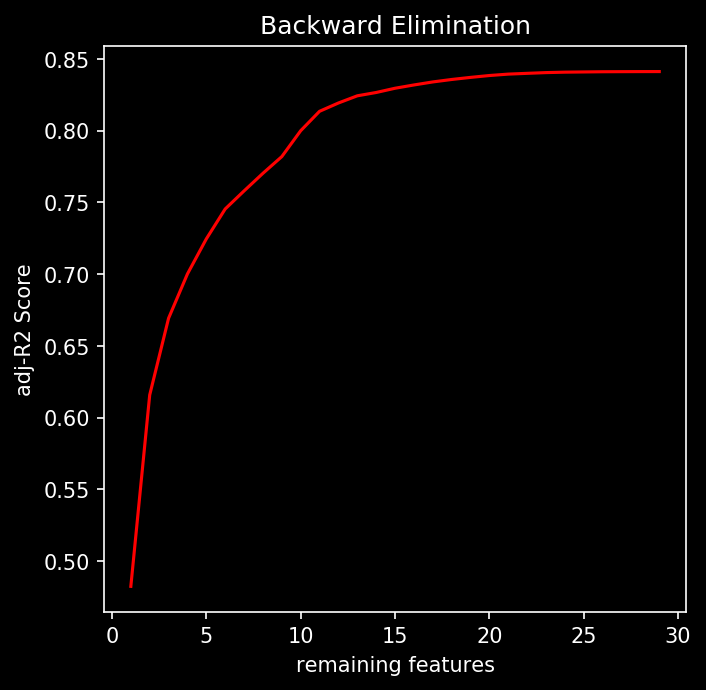

In [41]:
plt.figure(figsize = (5,5), dpi = 150)
plt.plot(range(len(history),0,-1), history, color = 'red')
plt.xlabel('remaining features')
plt.ylabel('adj-R2 Score')
#plt.yticks([z/100 for z in range()])
plt.title('Backward Elimination')